# Augmentation Examples

This notebook shows before and after comparisons of some of the possible augmentations.  
The configurations of the augments in this notebook are close to the default configurations used for experiments.

## Imports, Dataset Loading & Helper Funtions

In [46]:
import matplotlib.pyplot as plt
import torch
import IPython.display as ipd

from birdset.datamodule.components.augmentations import AudioAugmentor

In [47]:
from birdset.datamodule import DatasetConfig, LoaderConfig, LoadersConfig
from birdset.datamodule.birdset_datamodule import BirdSetDataModule, BirdSetTransformsWrapper
dataset_config = DatasetConfig(
        data_dir='../data_birdset/HSN',
        dataset_name='HSN',
        hf_path='DBD-research-group/BirdSet',
        hf_name='HSN',
        n_workers=3,
        val_split=0.2,
        task="multilabel",
        classlimit=500,
        subset=10,
        eventlimit=5,
        sampling_rate=32000,
    )
datamodule = BirdSetDataModule(
    dataset=dataset_config,
    loaders=LoadersConfig(LoaderConfig(batch_size=3, shuffle=False)),
    transforms=BirdSetTransformsWrapper(model_type='waveform')
)

datamodule.prepare_data()
datamodule.setup("fit")
train_dataloader = datamodule.train_dataloader()

Event Mapping (num_proc=3):   0%|          | 0/10 [00:00<?, ? examples/s]

smart-sampling-1:   0%|          | 0/35 [00:00<?, ? examples/s]

One-hot-encoding (num_proc=3):   0%|          | 0/35 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/28 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/12000 [00:00<?, ? examples/s]

In [48]:
def process(input: torch.Tensor, 
               spectrogram_augmentations=None,
               waveform_augmentations=None,
               n_fft=1024,
               hop_length=512,
               n_mels = None,
              ):
    audio_augmentor = AudioAugmentor(sample_rate = dataset_config.sampling_rate, 
                                     use_spectrogram=True,
                                     spectrogram_augmentations = spectrogram_augmentations,
                                     waveform_augmentations = waveform_augmentations,
                                     n_fft=n_fft,
                                     hop_length=hop_length,
                                     n_mels=n_mels,
                                     db_scale=True)
    audio_augmented = audio_augmentor.combined_augmentations(input)
    
    return audio_augmented

## Waveform Augmentations

### Multilabel Mix

In [66]:
from birdset.datamodule.components.augmentations import MultilabelMix

multilabel_mix = MultilabelMix(
    min_snr_in_db=3.0,
    max_snr_in_db=30.0,
    mix_target="union",
    p=1
)

def multilabel_mix_transform(input: torch.Tensor, labels: torch.Tensor):
    multilabel_mix.randomize_parameters(samples=input,targets=labels)
    return multilabel_mix.apply_transform(samples=input,targets=labels)

In [67]:
data = next(iter(train_dataloader))
original_audio : torch.Tensor = data["input_values"]
original_audio_labels : torch.Tensor = data["labels"]
ipd.Audio(data=original_audio[0].squeeze(), rate=dataset_config.sampling_rate)

In [68]:
processed_dict = multilabel_mix_transform(original_audio, original_audio_labels)
processed_audio = processed_dict["samples"]
processed_audio_labels = processed_dict["targets"]
ipd.Audio(data=processed_audio[0].squeeze(), rate=dataset_config.sampling_rate)

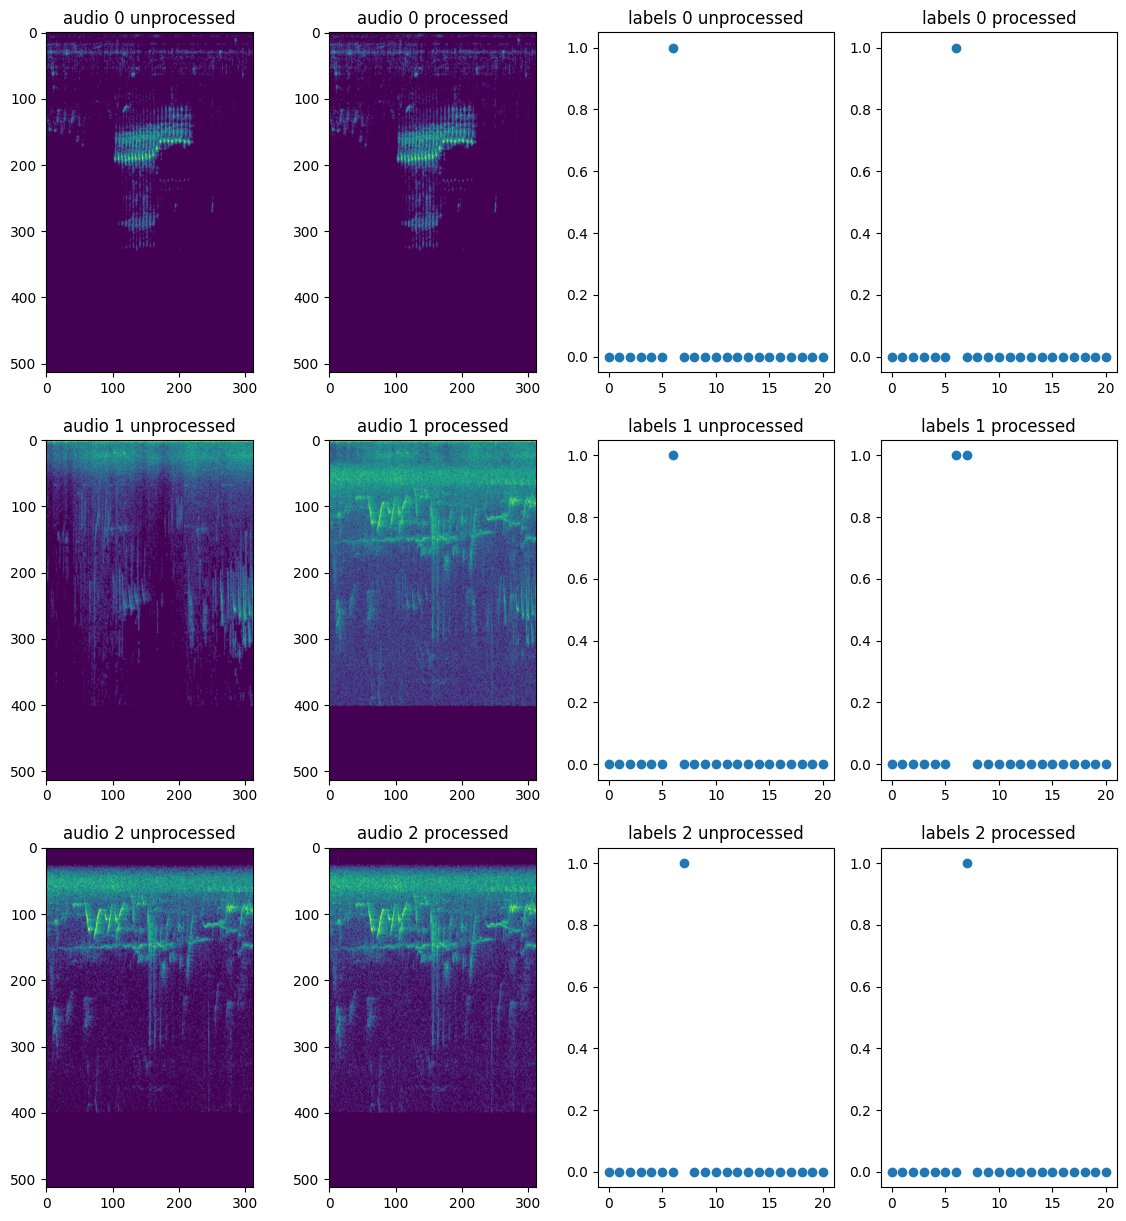

In [76]:
import numpy


original_image_data = process(original_audio).squeeze()
processed_image_data = process(processed_audio).squeeze()

fig, axeslist = plt.subplots(ncols=4, nrows=datamodule.loaders_config.train.batch_size)
fig.set_size_inches(14 , 15)
for row in range(datamodule.loaders_config.train.batch_size):
    axeslist.ravel()[row * 4].imshow(original_image_data[row].numpy())
    axeslist.ravel()[row * 4].set_title(f"audio {row} unprocessed")
    axeslist.ravel()[row * 4 + 1].imshow(processed_image_data[row].numpy())
    axeslist.ravel()[row * 4 + 1].set_title(f"audio {row} processed")
    
    axeslist.ravel()[row * 4 + 2].scatter(
        x=numpy.array(range(len(original_audio_labels[row]))),
        y=original_audio_labels[row].numpy())
    axeslist.ravel()[row * 4 + 2].set_title(f"labels {row} unprocessed")
    axeslist.ravel()[row * 4 + 3].scatter(
        x=numpy.array(range(len(original_audio_labels[row]))),
        y=processed_audio_labels[row].numpy())
    axeslist.ravel()[row * 4 + 3].set_title(f"labels {row} processed")


### Background Noise

For this augment you need to have background noise files downloaded.  
You can do that with the "download_background_noise.py" script.

In [53]:
from birdset.datamodule.components.augmentations import AddBackgroundNoise

background_noise = AddBackgroundNoise(
    min_snr_in_db=3,
    max_snr_in_db=30,
    sample_rate=dataset_config.sampling_rate,
    target_rate=dataset_config.sampling_rate,
    p=1,
    background_paths="../data_birdset/background_noise/dcase18_wav"
)

def add_background_noise(input: torch.Tensor):
    background_noise.randomize_parameters(samples=input, sample_rate=dataset_config.sampling_rate)
    return background_noise.apply_transform(input)["samples"]

In [54]:
data = next(iter(train_dataloader))
original_audio : torch.Tensor = data["input_values"][0].unsqueeze(0)
ipd.Audio(data=original_audio.squeeze(), rate=dataset_config.sampling_rate)

In [55]:
processed_audio : torch.Tensor = add_background_noise(original_audio)
ipd.Audio(data=processed_audio.squeeze(), rate=dataset_config.sampling_rate)

### Colored Noise

In [56]:
from torch_audiomentations import AddColoredNoise

colored_noise = AddColoredNoise(
    min_f_decay=-2,
    max_f_decay=2,
    min_snr_in_db=3,
    max_snr_in_db=30,
    p=1
)

def add_colored_noise(input: torch.Tensor):
    colored_noise.randomize_parameters(input)
    return colored_noise.apply_transform(input, sample_rate=dataset_config.sampling_rate)["samples"]

In [57]:
data = next(iter(train_dataloader))
original_audio : torch.Tensor = data["input_values"][0].unsqueeze(0)
ipd.Audio(data=original_audio.squeeze(), rate=dataset_config.sampling_rate)

In [58]:
processed_audio : torch.Tensor = add_colored_noise(original_audio)
ipd.Audio(data=processed_audio.squeeze(), rate=dataset_config.sampling_rate)

### Gain

In [59]:
from torch_audiomentations import Gain

gain = Gain(
    min_gain_in_db=-100,
    max_gain_in_db=-50,
    p=1
)

def gain_transform(input: torch.Tensor):
    gain.randomize_parameters(input)
    return gain.apply_transform(input)["samples"]

In [60]:
data = next(iter(train_dataloader))
original_audio : torch.Tensor = data["input_values"][0].unsqueeze(0)
ipd.Audio(data=original_audio.squeeze(), rate=dataset_config.sampling_rate)

In [61]:
processed_audio : torch.Tensor = gain_transform(original_audio)
ipd.Audio(data=processed_audio.squeeze(), rate=dataset_config.sampling_rate)

Text(0.5, 1.0, 'processed')

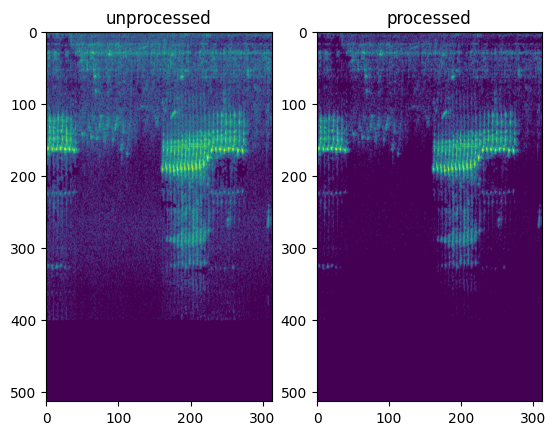

In [62]:
original_image_data = process(original_audio)
processed_image_data = process(processed_audio)

fig, axeslist = plt.subplots(ncols=2, nrows=1)
axeslist.ravel()[0].imshow(original_image_data.squeeze().numpy())
axeslist.ravel()[0].set_title("unprocessed")
axeslist.ravel()[1].imshow(processed_image_data.squeeze().numpy())
axeslist.ravel()[1].set_title("processed")

## Spectrogram Augments

### Frequency Masking

Text(0.5, 1.0, 'processed')

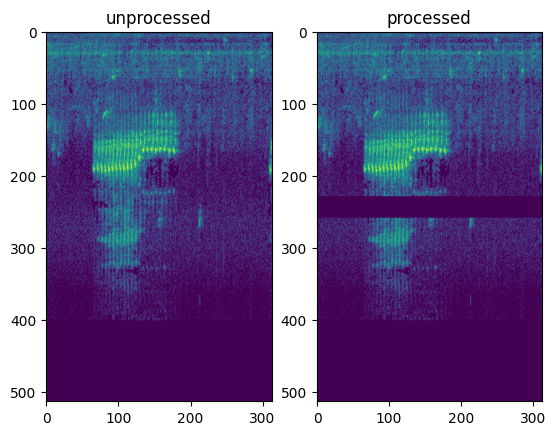

In [63]:
spectogram_augment_dict = {"frequency_masking": {"freq_mask_param": 100, "prob": 1, "iid_masks": True}}

data = next(iter(train_dataloader))
original_audio : torch.Tensor = data["input_values"][0].unsqueeze(0)
original_image_data = process(original_audio)
processed_image_data = process(original_audio, spectrogram_augmentations=spectogram_augment_dict)

fig, axeslist = plt.subplots(ncols=2, nrows=1)
axeslist.ravel()[0].imshow(original_image_data.squeeze().numpy())
axeslist.ravel()[0].set_title("unprocessed")
axeslist.ravel()[1].imshow(processed_image_data.squeeze().numpy())
axeslist.ravel()[1].set_title("processed")

### Time Masking

Text(0.5, 1.0, 'processed')

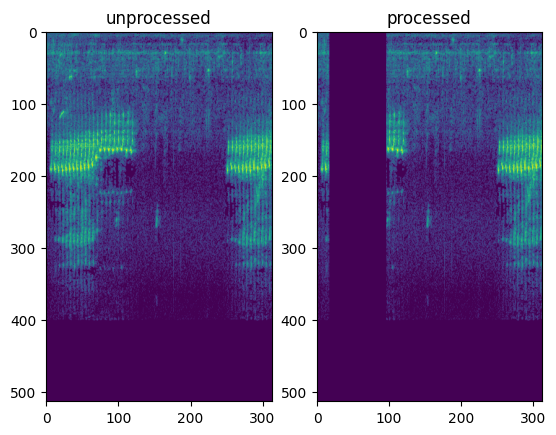

In [64]:
spectogram_augment_dict = {"time_masking": {"time_mask_param": 100, "prob": 1, "iid_masks": True}}

data = next(iter(train_dataloader))
original_audio : torch.Tensor = data["input_values"][0].unsqueeze(0)
original_image_data = process(original_audio)
processed_image_data = process(original_audio, spectrogram_augmentations=spectogram_augment_dict)

fig, axeslist = plt.subplots(ncols=2, nrows=1)
axeslist.ravel()[0].imshow(original_image_data.squeeze().numpy())
axeslist.ravel()[0].set_title("unprocessed")
axeslist.ravel()[1].imshow(processed_image_data.squeeze().numpy())
axeslist.ravel()[1].set_title("processed")

## No-Calls

In [92]:
from birdset.datamodule.components.augmentations import NoCallMixer

no_call = NoCallMixer(
    directory="../data_birdset/background_noise/dcase18_wav",
    p=1,
    sampling_rate=dataset_config.sampling_rate
)

In [93]:
data = next(iter(train_dataloader))
original_audio = data["input_values"][0].unsqueeze(0)
original_audio_labels = data["labels"][0].unsqueeze(0)
print(original_audio_labels)
ipd.Audio(data=original_audio.squeeze(), rate=dataset_config.sampling_rate)

tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]], dtype=torch.float16)


In [94]:
processed_audio, processed_audio_labels = no_call(original_audio, original_audio_labels)
print(processed_audio_labels)
ipd.Audio(data=processed_audio.squeeze(), rate=dataset_config.sampling_rate)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=torch.float16)
